episode:   0 | score:   1 | epsilon: 0.999


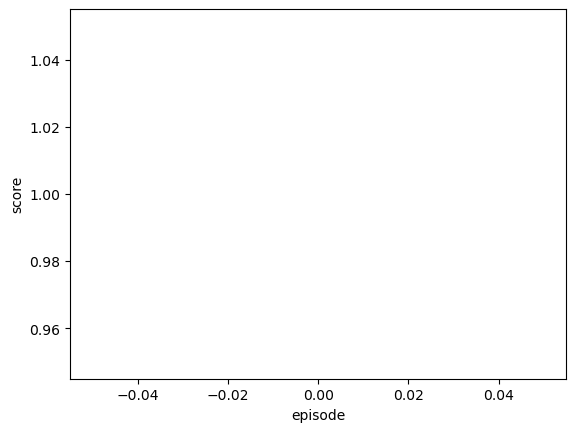

tf.Tensor([[ 0.13989052 -0.6147008  -0.3598695   0.02612967 -0.25860947]], shape=(1, 5), dtype=float32)


TclError: invalid command name ".!canvas"

In [1]:
import copy
import pylab
import random
import numpy as np
from environment_deepsarsa import Env
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# 딥살사 인공신경망
class DeepSARSA(tf.keras.Model):
    def __init__(self, action_size):  # action_size = 5
        super(DeepSARSA, self).__init__()
        self.fc1 = Dense(30, activation='relu')
        self.fc2 = Dense(30, activation='relu')
        self.fc_out = Dense(action_size)  # 출력층은 5개로

    def call(self, x):  
        x = self.fc1(x)  # x를 입력받아 x를 출력
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 그리드월드 예제에서의 딥살사 에이전트
class DeepSARSAgent:
    def __init__(self, state_size, action_size):
        # 상태의 크기와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        
        # 딥살사 하이퍼 파라메터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.  
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.01
        self.model = DeepSARSA(self.action_size)  # 위에 모델
        self.optimizer = Adam(learning_rate=self.learning_rate)  # Adam 이라는 수식에 learning_rate 의 걸음을 넣어줌

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # 입실론 값보다 작거나 같은 값이 뽑히면
            return random.randrange(self.action_size)  # [0, 1, 2, 3, 4] 중에 임의로 이동
        else:
            q_values = self.model(state)  # 아니면 self.model()에 state(15개의 입력을 넣어준다)를 def_call에 x가 곧 state임
            return np.argmax(q_values[0])  # [[[],[]]][0] = [[],[]]

    # <s, a, r, s', a'>의 샘플로부터 모델 업데이트
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # 현재 입실론이 0.01보다 크면 0.9999를 곱해준다 

        # 학습 파라메터
        model_params = self.model.trainable_variables  # trainable_variables에 의해 임의이 값이 w가중치로 들어가서 계산이 시작된다. // 15개가 30개로 들어가고 30개가 30개로 중간중간 b가 더해지는
        with tf.GradientTape() as tape:  # 잘모르겠음
            tape.watch(model_params)  # 잘모르겠음
            predict = self.model(state)[0]  # 다섯개의 소수점이 2차원 리스트로 나오므로 1차원으로 뽑기위해 0
            one_hot_action = tf.one_hot([action], self.action_size)  # 액션은 1,2,3,4,5중에서 하나를 뽑고 [1,2,3,4,5]에서 나온값을 제외하고 0으로 바꿔준다 나온건 1
            predict = tf.reduce_sum(one_hot_action * predict, axis=1)  # 다시 소수점으로 바꿔주고 1이었던 남은 소수점하나만 살리기위해 더해줌

            # done = True 일 경우 에피소드가 끝나서 다음 상태가 없음
            next_q = self.model(next_state)[0][next_action]  # 2차원리스트에서 1차원으로 바꿔준 다섯개의 상태에서 다음 행동 하나를 선택해서 밑으로 보내주고
            target = reward + (1 - done) * self.discount_factor * next_q

            # MSE 오류 함수 계산
            loss = tf.reduce_mean(tf.square(target - predict))  # reduce_mean 1차원리스트를 빼준다.
        
        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)  # model_params의 6가지 가중치에 오류함수와 gradient를 통해서 가중치에 대한 비율를 구해주고 
        self.optimizer.apply_gradients(zip(grads, model_params))  # grads 에 저장된 각각의 비중과 가중치를 apply_gradients를 이용해서 업데이트해준다.


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env(render_speed=0.01)
    state_size = 15
    action_space = [0, 1, 2, 3, 4]
    action_size = len(action_space)
    agent = DeepSARSAgent(state_size, action_size)
    
    scores, episodes = [], []

    EPISODES = 5
    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()ㄴ
        state = np.reshape(state, [1, state_size])

        while not done:
            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            next_action = agent.get_action(next_state)

            # 샘플로 모델 학습
            agent.train_model(state, action, reward, next_state, 
                                next_action, done)
            score += reward
            state = next_state

            if done:
                # 에피소드마다 학습 결과 출력
                print("episode: {:3d} | score: {:3d} | epsilon: {:.3f}".format(
                      e, score, agent.epsilon))

                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("score")
                pylab.savefig("./save_graph/graph.png")
                pylab.show()



        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights('save_model/model', save_format='tf')

In [11]:
np.argmax([[-0.55592585], [-0.7712781],   [0.9211373] , [-0.8641545] , [-0.3696173 ]])

2